# Visualize Sample Patches for Expert Scoring

## Setup + Helper Functions

In [1]:
import os
from pathlib import Path
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt


In [ ]:
def load_nifti(path: Path) -> np.ndarray:
    return nib.load(str(path)).get_fdata()


In [ ]:
def center_slice(vol: np.ndarray) -> np.ndarray:
    z = vol.shape[2] // 2
    return vol[:, :, z]


In [ ]:
def find_flat_patch(
    root: Path,
    dataset: str,
    patch_id: int,
    channel: int,
) -> Path:
    ds_dir = root / dataset

    pattern = f"patch_{patch_id:03d}_vol*_ch{channel}.nii.gz"

    matches = [
        p for p in ds_dir.glob(pattern)
        if "_label" not in p.name
    ]

    if len(matches) == 0:
        raise FileNotFoundError(
            f"No image patch_{patch_id:03d}_ch{channel} found in {ds_dir}"
        )

    if len(matches) > 1:
        raise RuntimeError(
            f"Multiple GT matches for patch_{patch_id:03d}_ch{channel}: {matches}"
        )

    return matches[0]


In [5]:
def find_run_dir(root: Path, dataset: str, fold: int, trlim: int) -> Path:
    dataset_root = root / "preds" / dataset

    for run_dir in dataset_root.iterdir():
        if not run_dir.is_dir():
            continue
        name = run_dir.name
        if f"cvfold{fold}_" in name and f"_trlim{trlim}_" in name:
            return run_dir

    raise FileNotFoundError(
        f"No run dir found for dataset={dataset}, fold={fold}, trlim={trlim}"
    )


In [6]:
# Ground truth (sharp)
GT_ROOT = Path(
    "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches"
)


## Deblurring

In [7]:
# Blurred inputs
BLUR_ROOT = Path(
    "/midtier/paetzollab/scratch/ads4015/data_selma3d/selma3d_finetune_patches_blurred2"
)

# Predictions
PRED_ROOTS = {
    "Image + CLIP": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_autumn_sweep_27_v2"
    ),
    "Image-only": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_expert_sweep_31_v2"
    ),
    "Random init": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_deblur_preds_random_v2"
    ),
}


In [8]:
def find_pred_patch(
    run_dir: Path,
    patch_id: int,
    channel: int,
) -> Path:
    pred_dir = run_dir / "preds"

    pattern = f"patch_{patch_id:03d}_vol*_ch{channel}_deblur_pred.nii.gz"

    matches = list(pred_dir.glob(pattern))

    if len(matches) == 0:
        raise FileNotFoundError(
            f"No pred patch_{patch_id:03d}_ch{channel} in {pred_dir}"
        )

    if len(matches) > 1:
        raise RuntimeError(
            f"Multiple pred matches for patch_{patch_id:03d}_ch{channel}: {matches}"
        )

    return matches[0]


In [9]:
DEBLUR_VIS_CONFIG = [
    {
        "dataset": "amyloid_plaque_patches",
        "cvfold": 0,
        "trlim": 19,
        "patch": 7,
        "channel": 0,
    },
    {
        "dataset": "amyloid_plaque_patches",
        "cvfold": 1,
        "trlim": 18,
        "patch": 2,
        "channel": 0,
    },
    {
        "dataset": "c_fos_positive_patches",
        "cvfold": 0,
        "trlim": 4,
        "patch": 2,
        "channel": 0,
    },
    {
        "dataset": "c_fos_positive_patches",
        "cvfold": 1,
        "trlim": 3,
        "patch": 1,
        "channel": 0,
    },
    {
        "dataset": "cell_nucleus_patches",
        "cvfold": 0,
        "trlim": 25,
        "patch": 6,
        "channel": 0,
    },
    {
        "dataset": "cell_nucleus_patches",
        "cvfold": 1,
        "trlim": 24,
        "patch": 10,
        "channel": 0,
    },
    {
        "dataset": "vessels_patches",
        "cvfold": 0,
        "trlim": 20,
        "patch": 0,
        "channel": 0,
    },
    {
        "dataset": "vessels_patches",
        "cvfold": 1,
        "trlim": 19,
        "patch": 6,
        "channel": 0,
    },
]



In [10]:
def render_deblur_from_config(config):

    n_rows = len(config)
    n_cols = 6  # Config | Blurred | GT | Image+CLIP | Image-only | Random

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(20, 4 * n_rows),
        constrained_layout=True,
    )

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, cfg in enumerate(config):

        dataset = cfg["dataset"]
        fold = cfg["cvfold"]
        trlim = cfg["trlim"]
        patch_id = cfg["patch"]
        channel = cfg["channel"]

        # ---------------------------
        # Config text (column 0)
        # ---------------------------
        ax_text = axes[r, 0]
        ax_text.axis("off")

        config_text = (
            f"dataset : {dataset}\n"
            f"cvfold  : {fold}\n"
            f"trlim   : {trlim}\n"
            f"patch   : {patch_id:03d}\n"
            f"channel : ch{channel}"
        )

        ax_text.text(
            0.0,
            0.5,
            config_text,
            fontsize=11,
            family="monospace",
            va="center",
            ha="left",
        )

        # ---------------------------
        # Load GT / blurred
        # ---------------------------
        gt = load_nifti(
            find_flat_patch(GT_ROOT, dataset, patch_id, channel)
        )
        blur = load_nifti(
            find_flat_patch(BLUR_ROOT, dataset, patch_id, channel)
        )

        gt_slice = center_slice(gt)
        blur_slice = center_slice(blur)

        # ---------------------------
        # Load predictions
        # ---------------------------
        preds = {}
        for label, root in PRED_ROOTS.items():
            run_dir = find_run_dir(root, dataset, fold, trlim)
            pred_path = find_pred_patch(run_dir, patch_id, channel)
            preds[label] = center_slice(load_nifti(pred_path))

        images = [blur_slice, gt_slice] + list(preds.values())
        titles = ["Blurred", "Ground Truth"] + list(preds.keys())

        for c, (img, title) in enumerate(zip(images, titles), start=1):
            ax = axes[r, c]
            ax.imshow(img, cmap="gray")
            ax.axis("off")

            if r == 0:
                ax.set_title(title, fontsize=12)

    plt.suptitle("Deblurring Results (Config-Driven)", fontsize=16)
    plt.show()


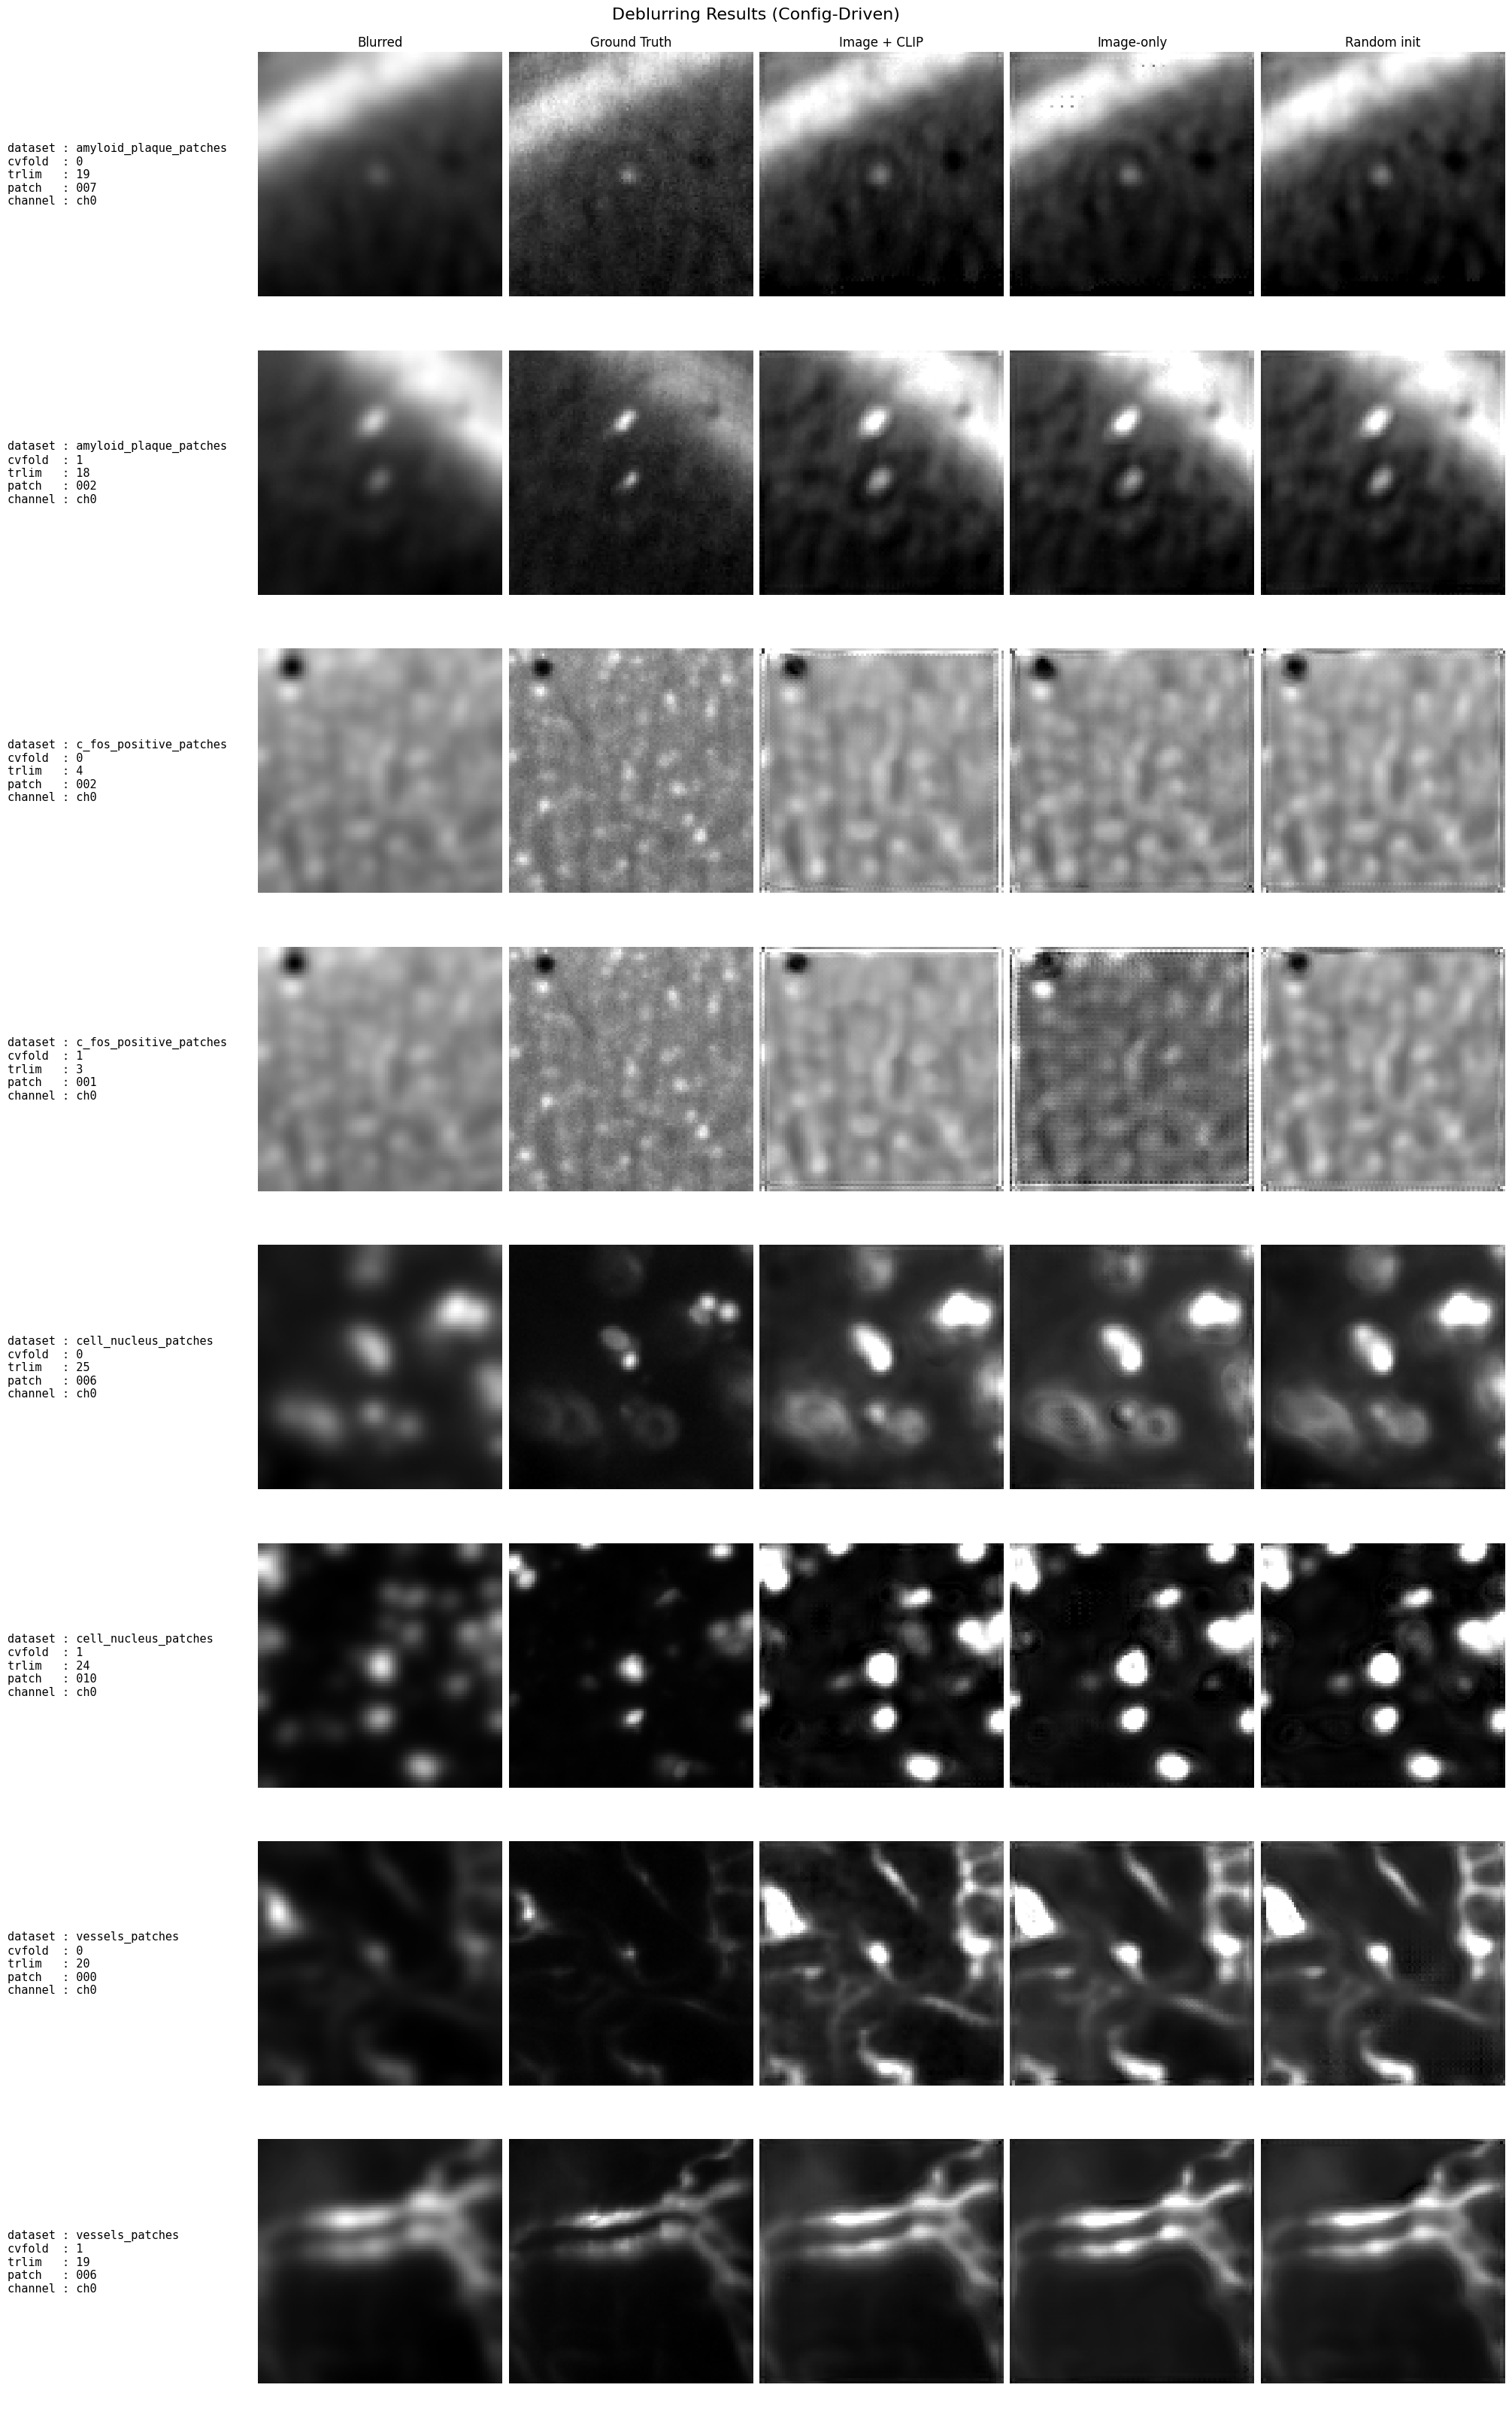

In [11]:
render_deblur_from_config(DEBLUR_VIS_CONFIG)


## Segmentation

In [12]:
SEG_PRED_ROOTS = {
    "Image + CLIP": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_autumn_sweep_27_v2"
    ),
    "Image-only": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_expert_sweep_31_v2"
    ),
    "Random init": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_segmentation_preds_rand_v2"
    ),
}


In [13]:
def find_flat_label(
    root: Path,
    dataset: str,
    patch_id: int,
    channel: int,
) -> Path:
    ds_dir = root / dataset

    pattern = f"patch_{patch_id:03d}_vol*_ch{channel}_label.nii.gz"
    matches = list(ds_dir.glob(pattern))

    if len(matches) == 0:
        raise FileNotFoundError(
            f"No label patch_{patch_id:03d}_ch{channel} found in {ds_dir}"
        )

    if len(matches) > 1:
        raise RuntimeError(
            f"Multiple label matches for patch_{patch_id:03d}_ch{channel}: {matches}"
        )

    return matches[0]


In [14]:
def seg_dataset_name(dataset: str) -> str:
    """
    Convert GT dataset name to segmentation prediction folder name.
    Example:
        amyloid_plaque_patches -> amyloid_plaque
    """
    if dataset.endswith("_patches"):
        return dataset.replace("_patches", "")
    return dataset


In [15]:
def find_seg_run_dir(root: Path, dataset: str, fold: int, trlim: int) -> Path:
    dataset_seg = seg_dataset_name(dataset)
    dataset_root = root / "preds" / dataset_seg

    matches = []
    for run_dir in dataset_root.iterdir():
        if not run_dir.is_dir():
            continue
        name = run_dir.name
        if f"cvfold{fold}_" in name and f"_trlim{trlim}_" in name:
            matches.append(run_dir)

    if len(matches) == 0:
        raise FileNotFoundError(
            f"No seg run dir found for dataset={dataset_seg}, fold={fold}, trlim={trlim}"
        )

    if len(matches) > 1:
        raise RuntimeError(
            f"Multiple seg run dirs found for dataset={dataset_seg}, "
            f"fold={fold}, trlim={trlim}:\n{matches}"
        )

    return matches[0]


In [16]:
def find_seg_pred_patch(
    run_dir: Path,
    patch_id: int,
    channel: int,
) -> Path:
    pred_dir = run_dir / "preds"

    pattern = f"patch_{patch_id:03d}_vol*_ch{channel}_pred_*.nii.gz"
    matches = list(pred_dir.glob(pattern))

    if len(matches) == 0:
        raise FileNotFoundError(
            f"No segmentation pred for patch_{patch_id:03d}_ch{channel} in {pred_dir}"
        )

    if len(matches) > 1:
        raise RuntimeError(
            f"Multiple segmentation preds for patch_{patch_id:03d}_ch{channel}: {matches}"
        )

    return matches[0]


In [17]:
SEG_VIS_CONFIG = [
    {
        "dataset": "amyloid_plaque_patches",
        "cvfold": 0,
        "trlim": 17,
        "patch": 7,
        "channel": 0,
    },
    {
        "dataset": "amyloid_plaque_patches",
        "cvfold": 1,
        "trlim": 16,
        "patch": 2,
        "channel": 0,
    },
    {
        "dataset": "c_fos_positive_patches",
        "cvfold": 0,
        "trlim": 2,
        "patch": 2,
        "channel": 0,
    },
    {
        "dataset": "c_fos_positive_patches",
        "cvfold": 1,
        "trlim": 2,
        "patch": 1,
        "channel": 0,
    },
    {
        "dataset": "cell_nucleus_patches",
        "cvfold": 0,
        "trlim": 23,
        "patch": 6,
        "channel": 0,
    },
    {
        "dataset": "cell_nucleus_patches",
        "cvfold": 1,
        "trlim": 22,
        "patch": 10,
        "channel": 0,
    },
    {
        "dataset": "vessels_patches",
        "cvfold": 0,
        "trlim": 18,
        "patch": 0,
        "channel": 0,
    },
    {
        "dataset": "vessels_patches",
        "cvfold": 1,
        "trlim": 17,
        "patch": 6,
        "channel": 0,
    },
]



In [18]:
def render_segmentation_from_config(config):

    n_rows = len(config)
    n_cols = 6  # Config | Image | GT Mask | 3 model preds

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(20, 4 * n_rows),
        constrained_layout=True,
    )

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, cfg in enumerate(config):

        dataset = cfg["dataset"]
        fold = cfg["cvfold"]
        trlim = cfg["trlim"]
        patch_id = cfg["patch"]
        channel = cfg["channel"]

        # ---------------------------
        # Config text column
        # ---------------------------
        ax_text = axes[r, 0]
        ax_text.axis("off")

        ax_text.text(
            0.0,
            0.5,
            (
                f"dataset : {dataset}\n"
                f"cvfold  : {fold}\n"
                f"trlim   : {trlim}\n"
                f"patch   : {patch_id:03d}\n"
                f"channel : ch{channel}"
            ),
            fontsize=11,
            family="monospace",
            va="center",
        )

        # ---------------------------
        # Load image + label
        # ---------------------------
        img = load_nifti(
            find_flat_patch(GT_ROOT, dataset, patch_id, channel)
        )
        label = load_nifti(
            find_flat_label(GT_ROOT, dataset, patch_id, channel)
        )

        img_slice = center_slice(img)
        label_slice = center_slice(label)

        # ---------------------------
        # Load predictions
        # ---------------------------
        preds = {}
        for name, root in SEG_PRED_ROOTS.items():
            run_dir = find_seg_run_dir(root, dataset, fold, trlim)
            pred_path = find_seg_pred_patch(run_dir, patch_id, channel)
            preds[name] = center_slice(load_nifti(pred_path))

        images = [img_slice, label_slice] + list(preds.values())
        titles = ["Image", "GT Mask"] + list(preds.keys())

        for c, (img2d, title) in enumerate(zip(images, titles), start=1):
            ax = axes[r, c]
            ax.imshow(img2d, cmap="gray", interpolation="nearest")
            ax.axis("off")

            if r == 0:
                ax.set_title(title, fontsize=12)


    plt.suptitle("Segmentation Results (Config-Driven)", fontsize=16)
    plt.show()


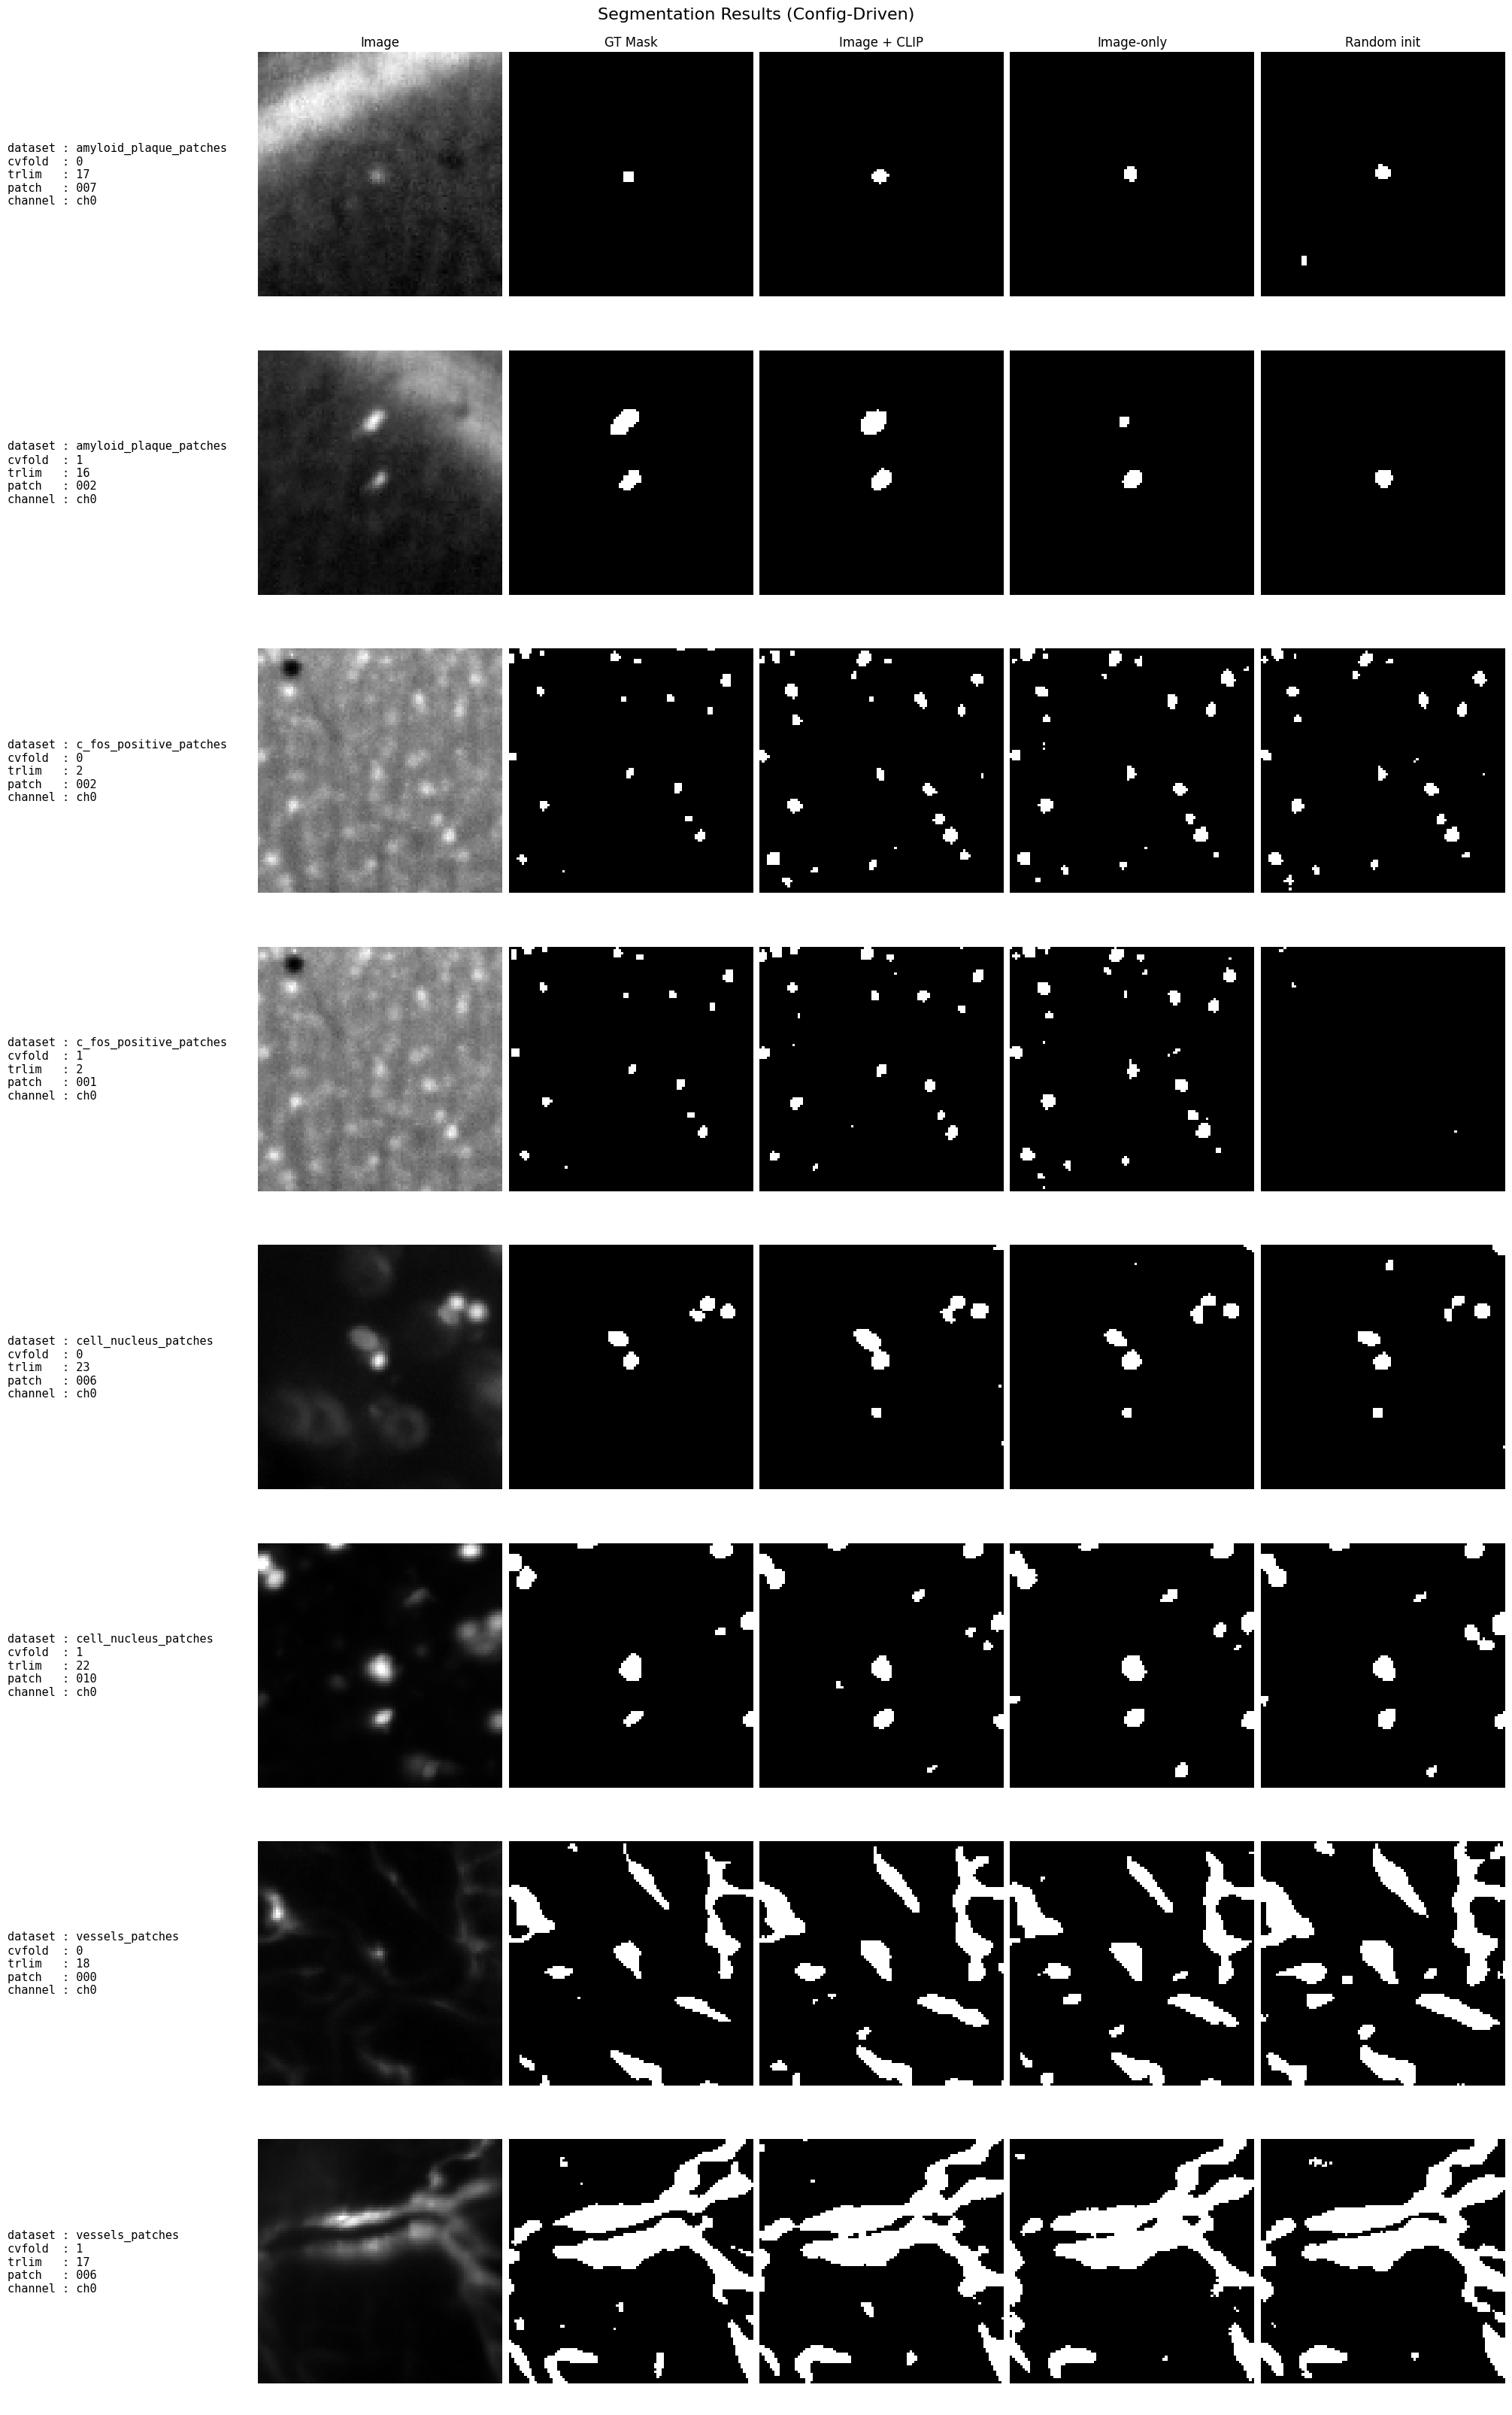

In [19]:
render_segmentation_from_config(SEG_VIS_CONFIG)


## Inpainting

In [20]:
INPAINT_PRED_ROOTS = {
    "Image + CLIP": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27"
    ),
    "Image-only": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31"
    ),
    "Rand init": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random"
    ),
    "Image + CLIP (no ft text)": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_autumn_sweep_27_ntc"
    ),
    "Image-only (no ft text)": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_expert_sweep_31_ntc"
    ),
    "Rand init (no ft text)": Path(
        "/midtier/paetzollab/scratch/ads4015/temp_selma_inpaint_preds_random_ntc"
    ),
}


In [21]:
def find_inpaint_run_dir(root: Path, dataset: str, fold: int, trlim: int) -> Path:
    dataset_root = root / "preds" / dataset

    matches = []
    for run_dir in dataset_root.iterdir():
        if not run_dir.is_dir():
            continue
        name = run_dir.name
        if f"cvfold{fold}_" in name and f"_trlim{trlim}_" in name:
            matches.append(run_dir)

    if len(matches) == 0:
        raise FileNotFoundError(
            f"No inpaint run dir for dataset={dataset}, fold={fold}, trlim={trlim}"
        )
    if len(matches) > 1:
        raise RuntimeError(
            f"Multiple inpaint run dirs for dataset={dataset}, fold={fold}, trlim={trlim}:\n{matches}"
        )

    return matches[0]


In [22]:
def find_inpaint_file(
    run_dir: Path,
    patch_id: int,
    channel: int,
    suffix: str,
) -> Path:
    pred_dir = run_dir / "preds"
    pattern = f"patch_{patch_id:03d}_vol*_ch{channel}_{suffix}.nii.gz"

    matches = list(pred_dir.glob(pattern))

    if len(matches) == 0:
        raise FileNotFoundError(
            f"No {suffix} for patch_{patch_id:03d}_ch{channel} in {pred_dir}"
        )
    if len(matches) > 1:
        raise RuntimeError(
            f"Multiple {suffix} matches for patch_{patch_id:03d}_ch{channel}: {matches}"
        )

    return matches[0]


In [23]:
def select_mask_slice(mask: np.ndarray) -> int:
    """
    Choose a slice index that contains masked voxels.
    Falls back to center slice if mask is empty.
    """
    z_sums = mask.sum(axis=(0, 1))
    nonzero = np.where(z_sums > 0)[0]

    if len(nonzero) == 0:
        return mask.shape[2] // 2

    return int(nonzero[len(nonzero) // 2])


In [24]:
INPAINT_VIS_CONFIG = [
    {
        "dataset": "amyloid_plaque_patches",
        "cvfold": 0,
        "trlim": 17,
        "patch": 7,
        "channel": 0,
    },
    {
        "dataset": "amyloid_plaque_patches",
        "cvfold": 1,
        "trlim": 16,
        "patch": 2,
        "channel": 0,
    },
    {
        "dataset": "c_fos_positive_patches",
        "cvfold": 0,
        "trlim": 2,
        "patch": 2,
        "channel": 0,
    },
    {
        "dataset": "c_fos_positive_patches",
        "cvfold": 1,
        "trlim": 2,
        "patch": 1,
        "channel": 0,
    },
    {
        "dataset": "cell_nucleus_patches",
        "cvfold": 0,
        "trlim": 23,
        "patch": 6,
        "channel": 0,
    },
    {
        "dataset": "cell_nucleus_patches",
        "cvfold": 1,
        "trlim": 22,
        "patch": 10,
        "channel": 0,
    },
    {
        "dataset": "vessels_patches",
        "cvfold": 0,
        "trlim": 18,
        "patch": 0,
        "channel": 0,
    },
    {
        "dataset": "vessels_patches",
        "cvfold": 1,
        "trlim": 17,
        "patch": 6,
        "channel": 0,
    },
]



In [25]:
# INPAINT_VIS_CONFIG = [
#     {
#         "dataset": "vessels_patches",
#         "cvfold": 0,
#         "trlim": 2,
#         "patch": 0,
#         "channel": 0,
#     },
# ]


In [26]:
def render_inpainting_from_config(config):

    n_rows = len(config)
    n_cols = 10  # Config + 9 image columns

    fig, axes = plt.subplots(
        n_rows,
        n_cols,
        figsize=(26, 4 * n_rows),
        constrained_layout=True,
    )

    if n_rows == 1:
        axes = np.expand_dims(axes, axis=0)

    for r, cfg in enumerate(config):

        dataset = cfg["dataset"]
        fold = cfg["cvfold"]
        trlim = cfg["trlim"]
        patch_id = cfg["patch"]
        channel = cfg["channel"]

        # ---------------------------
        # Config column
        # ---------------------------
        ax_text = axes[r, 0]
        ax_text.axis("off")
        ax_text.text(
            0.0,
            0.5,
            (
                f"dataset : {dataset}\n"
                f"cvfold  : {fold}\n"
                f"trlim   : {trlim}\n"
                f"patch   : {patch_id:03d}\n"
                f"channel : ch{channel}"
            ),
            fontsize=11,
            family="monospace",
            va="center",
        )

        # ---------------------------
        # Load GT image (flat)
        # ---------------------------
        gt = load_nifti(
            find_flat_patch(GT_ROOT, dataset, patch_id, channel)
        )

        # ---------------------------
        # Load mask & masked input from ANY model (they are identical)
        # ---------------------------
        ref_root = next(iter(INPAINT_PRED_ROOTS.values()))
        ref_run_dir = find_inpaint_run_dir(ref_root, dataset, fold, trlim)

        mask = load_nifti(
            find_inpaint_file(ref_run_dir, patch_id, channel, "mask")
        )
        masked_input = load_nifti(
            find_inpaint_file(ref_run_dir, patch_id, channel, "masked_input")
        )


        z = select_mask_slice(mask)

        gt_slice = gt[:, :, z]
        mask_slice = mask[:, :, z]
        masked_input_slice = masked_input[:, :, z]

        # ---------------------------
        # Load composite predictions
        # ---------------------------
        preds = {}
        for name, root in INPAINT_PRED_ROOTS.items():
            run_dir = find_inpaint_run_dir(root, dataset, fold, trlim)
            comp = load_nifti(
                find_inpaint_file(run_dir, patch_id, channel, "inpaint_composite")
            )
            preds[name] = comp # keep full 3D volume


        pred_slices = {k: v[:, :, z] for k, v in preds.items()}

        images = (
            [gt_slice, mask_slice, masked_input_slice]
            + list(pred_slices.values())
        )


        titles = (
            ["GT", "Mask", "Masked input"]
            + list(preds.keys())
        )

        for c, (img2d, title) in enumerate(zip(images, titles), start=1):
            ax = axes[r, c]
            ax.imshow(img2d, cmap="gray", interpolation="nearest")
            ax.axis("off")

            if r == 0:
                ax.set_title(title, fontsize=11)

        print(
            gt.shape,
            mask.shape,
            masked_input.shape,
            {k: v.shape for k, v in preds.items()}
        )

    plt.suptitle("Inpainting Results (Config-Driven)", fontsize=16)
    plt.show()


(96, 96, 96) (96, 96, 96) (96, 96, 96) {'Image + CLIP': (96, 96, 96), 'Image-only': (96, 96, 96), 'Rand init': (96, 96, 96), 'Image + CLIP (no ft text)': (96, 96, 96), 'Image-only (no ft text)': (96, 96, 96), 'Rand init (no ft text)': (96, 96, 96)}
(96, 96, 96) (96, 96, 96) (96, 96, 96) {'Image + CLIP': (96, 96, 96), 'Image-only': (96, 96, 96), 'Rand init': (96, 96, 96), 'Image + CLIP (no ft text)': (96, 96, 96), 'Image-only (no ft text)': (96, 96, 96), 'Rand init (no ft text)': (96, 96, 96)}
(96, 96, 96) (96, 96, 96) (96, 96, 96) {'Image + CLIP': (96, 96, 96), 'Image-only': (96, 96, 96), 'Rand init': (96, 96, 96), 'Image + CLIP (no ft text)': (96, 96, 96), 'Image-only (no ft text)': (96, 96, 96), 'Rand init (no ft text)': (96, 96, 96)}
(96, 96, 96) (96, 96, 96) (96, 96, 96) {'Image + CLIP': (96, 96, 96), 'Image-only': (96, 96, 96), 'Rand init': (96, 96, 96), 'Image + CLIP (no ft text)': (96, 96, 96), 'Image-only (no ft text)': (96, 96, 96), 'Rand init (no ft text)': (96, 96, 96)}
(96,

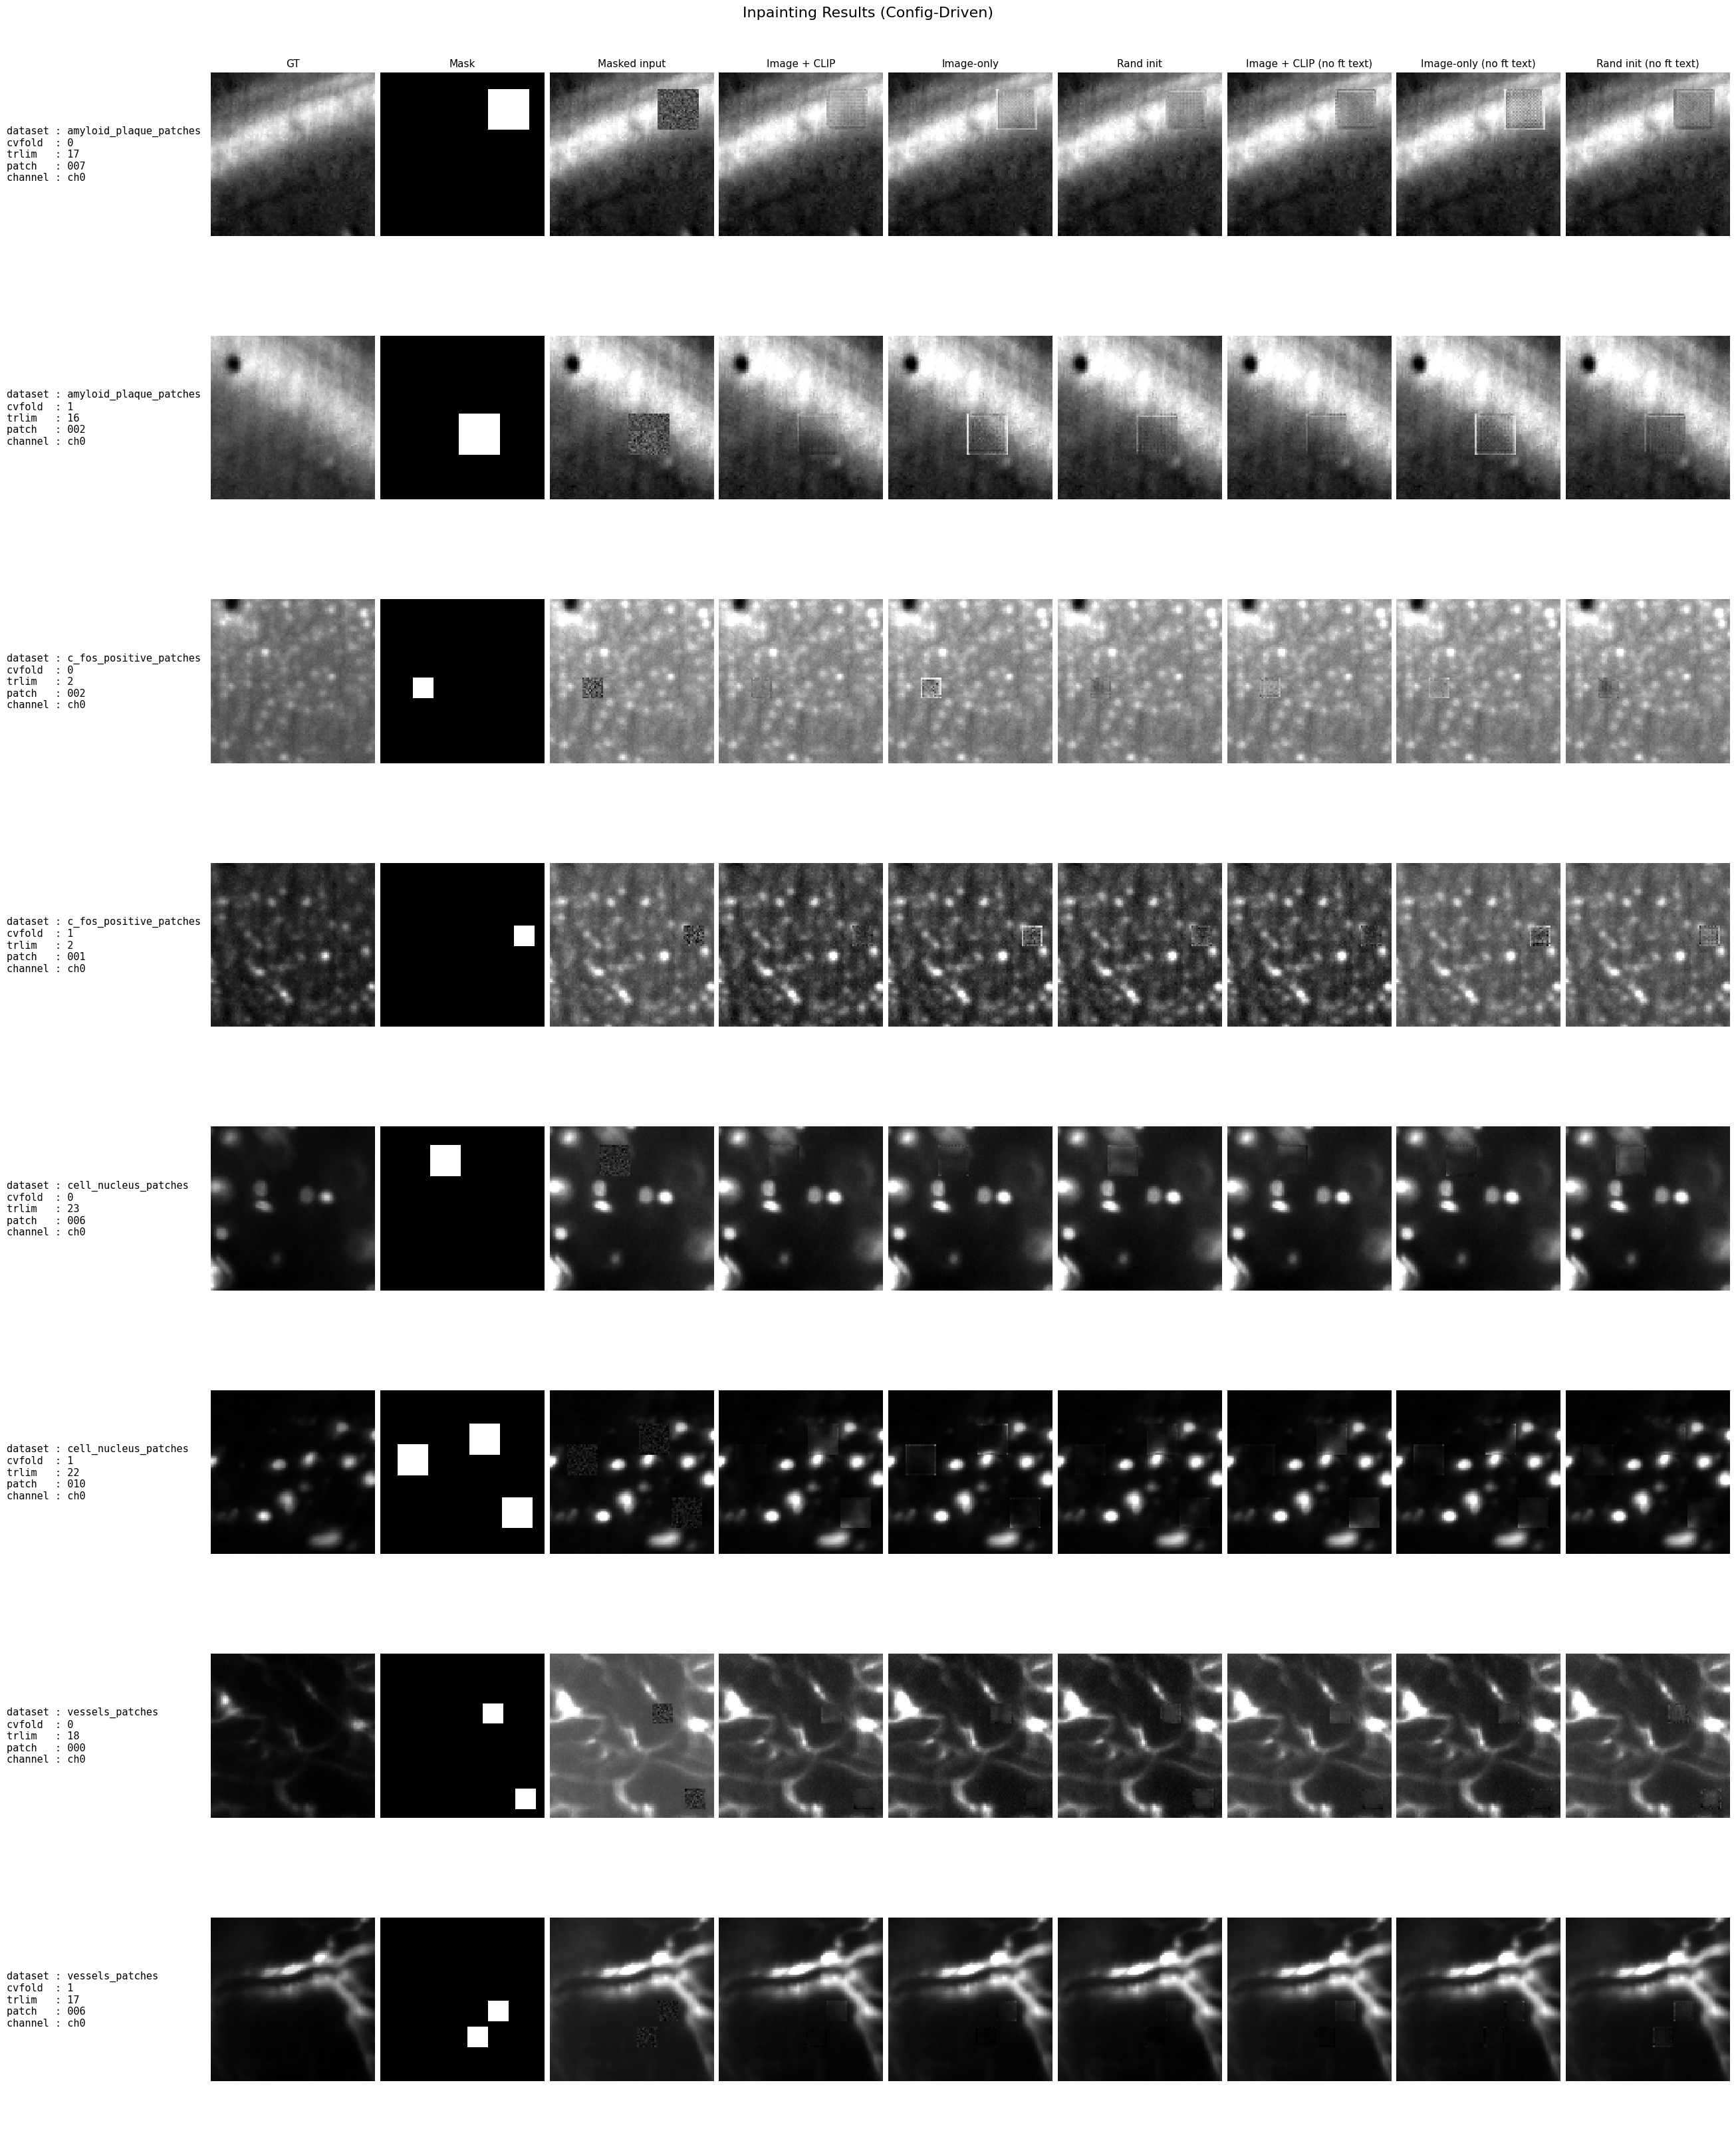

In [27]:
render_inpainting_from_config(INPAINT_VIS_CONFIG)
